# HM Land Registry Open Data
<details><summary>Data Analysis Problem:</summary>
<br>
Please download data from HM Land Registry Open Data, profile and clean the data and run some analyses, I am happy for you to use any language you prefer, but please submit both your code sample and your output. I am looking for these skills:
<pre>
1. Your ability to take a completely new dataset and make it ready for analysis (Data Engineering);
2. Defining questions you can answer from the data (Data Analysis);
3. Analyses and conclusions (Data Analysis)
</pre>
</details>


## Data Sources
[Land registry information](https://landregistry.data.gov.uk) used in this report is made available under the [Open Government License v3.0 (OGLv3.0)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)   
[Shape data for the uk](https://geoportal.statistics.gov.uk/datasets/counties-and-unitary-authorities-december-2020-uk-buc?geometry=-34.033%2C49.769%2C28.897%2C58.713) licensed under a [custom licence](https://www.ons.gov.uk/methodology/geography/licences) by Ordnance Survey and ONS  
[Population data](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland) available under [Open Government License v3.0 (OGLv3.0)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)   


## Import libraries

In [1]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.dates import DateFormatter
from pycaret.regression import *


## constant values

In [2]:
root_dir = os.path.abspath('.')

# Process transaction data into one file
## Rename archived files
rename raw datasets of transaction data .csv and save elsewhere. A few files were processed by hand due to not fitting with the internal structure or not having any meta data.

---

Move working directory

In [3]:
os.chdir(root_dir)
os.chdir("../RawData/TransactionData")

In [4]:
all_files = os.listdir()
write_protect = True
# Make sure code isn't accidentally run
if write_protect == False:
    for ifile in all_files:
        if ifile[-4:] == ".csv":
            with open(ifile) as file_open:
                file_open = open(ifile)
                file_read = file_open.read()
                name_loc = file_read.find(",")
            
                if file_read[0][0] == "\ufeff":
                    file_name = file_read[1:name_loc]
                    name_loc -= 1
                else:
                    file_name = file_read[:name_loc]


                if file_name == "Land Registry":
                    with open(ifile) as temp_read:
                        file_read = ''.join(temp_read.readlines()[2:])
                        name_loc = file_read.find(",")
                        file_name = file_read[:name_loc]

            if file_name.replace(' ','-')+'-' == ifile[:name_loc+1]:
                file_name = ifile
            else:
                month_start = file_read.find("Calendar Month,")+15
                month_end = file_read.find(',',month_start)
                date_name = file_read[month_start:month_end].split()
                if len(date_name) == 1:
                    date_name = date_name[0].split('-')
                    month_num = datetime.datetime.strptime(date_name[0],"%b").month+1
                else:
                    month_num = datetime.datetime.strptime(date_name[0],"%B").month+1
                
                if month_num == 13:
                    month_num = 1
                    date_name[1] = str(int(date_name[1])+1)

                file_name += " " + date_name[1] + " " + str(month_num).zfill(2) + ".csv"
                file_name = file_name.replace(' ','-')
            
            file_open.close()
            # Copy data to midpoint folder (TransactionDataRenamed) before concatination
            with  open("../TransactionDataRenamed/" + file_name, 'w') as new_file:
                new_file.write(file_read)
                new_file.close()

## Data Concatination
First check for missing files

In [5]:
os.chdir(root_dir)
os.chdir("../RawData/TransactionDataRenamed")

In [6]:
renamed_files = os.listdir()
renamed_files.sort()
unique_files = list(set([i[:-11] for i in renamed_files]))
log_missing = []

for file_type in unique_files:
    for year in range(2012,2022):
        for month in range(1,13):
            if year == 2021 and month > 4:
                break
            file_search = file_type+str(year)+'-'+str(month).zfill(2)+'.csv'
            if file_search in renamed_files:
                pass
            else:
                log_missing.append(file_search)
log_missing

['Number-of-applications-in-England-and-Wales-divided-by-region-2014-07.csv',
 'Number-of-applications-in-England-and-Wales-divided-by-local-authority-2014-07.csv',
 'Number-of-searches-by-all-account-customers-2014-07.csv',
 'Number-and-types-of-transactions-for-value-by-all-account-customers-2014-07.csv',
 'Number-and-types-of-applications-by-all-account-customers-2014-07.csv']

log_missing confirms only 2014-07 .csv files are missing, which appear to be a black spot in the data from switching between archive and current.  

---
Now concatinate all files together into one transaction file.

In [7]:
write_protect == True
if write_protect == False:
    a = []
    dict_df = {i:[] for i in unique_files}
    for ifile in renamed_files:
        tmp_df = pd.read_csv(ifile,
                        skiprows=4,
                        index_col=0)
        tmp_df['Date'] = ifile[-11:-4]
        dict_df[ifile[:-11]].append(tmp_df)

    for ikey in dict_df.keys():
        dict_df[ikey] = pd.concat(dict_df[ikey])
        dict_df[ikey].to_csv("../CleanTransaction/"+ikey[:-1]+".csv")

## Data cleaning  
Make the other remaining .csv ready for analysis. No post processing has been done due to the data being very thorough, with changes only made with how pandas reads in the csv by default (especially in the case of the price paid (pp) data which needs a large amount of columns culled before it can be read).

In [8]:
os.chdir(root_dir)
os.chdir('..')

In [9]:
pp_columns = ['Transaction unique identifier',      # 0
              'Price',                              # 1
              'Date of Transfer',                   # 2
              'Postcode',                           # 3
              'Property Type',                      # 4
              'Old/New',                            # 5
              'Duration',                           # 6
              'PAON',                               # 7
              'SAON',                               # 8
              'Street',                             # 9
              'Locality',                           # 10
              'Town/City',                          # 11
              'District',                           # 12
              'County',                             # 13
              'PPD Category Type',                  # 14
              'Record Status-monthly file only']    # 15
indexs = 1,2,3,4,5,6,7,9,11
pp_col_slice = [pp_columns[i] for i in indexs]
pp = pd.read_csv('RawData/PricePaidData/pp-complete.csv',
                 names=pp_col_slice,
                 usecols=indexs,
                #  index_col=9,#[5,1],#[2,13,12,11,10,9,8,7,3,0],
                 engine='c',
                 )

In [10]:
flats = pp['Property Type'] == 'D'
city = pp['Town/City'] == 'SOUTHAMPTON'
freehold = pp['Duration'] == 'F'
pp['Date of Transfer'] = pd.to_datetime(pp['Date of Transfer'])

pp = pp.iloc[:][(flats & city & freehold)]
pp = pp.drop(['Town/City','Property Type', 'Old/New', 'Duration','PAON'], axis=1)
time = pp['Date of Transfer'] >= pd.to_datetime("01,01,2010",dayfirst=True)
pp = pp.iloc[:][time]
pp.shape

(18830, 4)

In [11]:
pp.head()

,Price,Date of Transfer,Postcode,Street
16224330,277500,2010-04-27,SO40 8XX,OLEANDER DRIVE
16225055,186000,2010-07-23,SO16 6DD,COXFORD CLOSE
16225529,225000,2010-05-28,SO40 9BN,KINROSS ROAD
16226500,400000,2010-11-12,SO45 5AQ,MOUNTFIELD
16226509,230000,2010-03-31,SO15 2FX,HARBOROUGH ROAD


Attempting using above setting for full time series. ~~Select only transactions in Hampshire after 1-Jan-2020~~

In [12]:
# pp = pp.iloc[:][pp['Town/City'] == 'SOUTHAMPTON']
# pp['Date of Transfer'] = pd.to_datetime(pp['Date of Transfer'])
# pp = pp.iloc[:][pp['Date of Transfer'] >= pd.to_datetime("01,01,2019",dayfirst=True)]
# pp = pp.iloc[:][pp['Price'] <= 1*10**7]
# pp.head()

In [13]:
hpi = pd.read_csv('RawData/HPI/UK-HPI-full-file-2021-02.csv',
                  index_col='RegionName')
columns = ['Date','AreaCode', 
           'AveragePrice', 'Index', 'IndexSA', '1m%Change', '12m%Change', 'AveragePriceSA', 'SalesVolume', 
           'DetachedPrice', 'DetachedIndex', 'Detached1m%Change', 'Detached12m%Change',
           'SemiDetachedPrice', 'SemiDetachedIndex', 'SemiDetached1m%Change', 'SemiDetached12m%Change', 
           'TerracedPrice', 'TerracedIndex', 'Terraced1m%Change', 'Terraced12m%Change', 
           'FlatPrice', 'FlatIndex', 'Flat1m%Change', 'Flat12m%Change', 
           'CashPrice', 'CashIndex', 'Cash1m%Change', 'Cash12m%Change', 'CashSalesVolume', 
           'MortgagePrice', 'MortgageIndex', 'Mortgage1m%Change', 'Mortgage12m%Change', 'MortgageSalesVolume', 
           'FTBPrice', 'FTBIndex', 'FTB1m%Change', 'FTB12m%Change', 
           'FOOPrice', 'FOOIndex', 'FOO1m%Change','FOO12m%Change', 
           'NewPrice', 'NewIndex', 'New1m%Change', 'New12m%Change', 'NewSalesVolume', 
           'OldPrice', 'OldIndex', 'Old1m%Change', 'Old12m%Change', 'OldSalesVolume']
countries = ('England','Scotland','Wales','Northern Ireland')
hpi['Date'] = pd.to_datetime(hpi['Date'],dayfirst=True)


## Some machine learning  
Predict the sale price of a house

In [18]:
reg1 = setup(data = pp, target = 'Price', use_gpu=True)

,Description,Value
0,session_id,3182
1,Target,Price
2,Original Data,"(18830, 4)"
3,Missing Values,True
4,Numeric Features,0
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(13180, 4557)"


In [19]:
best_model = compare_models(fold=3, exclude=['lar','lr','par','knn','ada','et'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,91440.8694,38606536191.4087,194100.4931,0.2940,0.3025,0.2456,120.0200
ridge,Ridge Regression,91450.1979,38684581888.0000,194313.6771,0.2926,0.3029,0.2471,1.1133
lasso,Lasso Regression,92469.0026,41403433642.6667,200518.4062,0.2460,0.3052,0.2392,11.5133
rf,Random Forest Regressor,96014.7560,44037954971.8918,207229.5475,0.1954,0.3193,0.2366,304.7200
omp,Orthogonal Matching Pursuit,102669.0724,44594834428.0926,208481.3049,0.1840,0.3379,0.2722,1.1633
llar,Lasso Least Angle Regression,113749.2780,46624462218.2654,213660.7549,0.1411,0.3720,0.3212,1.6033
huber,Huber Regressor,101435.4330,47341351285.7057,216040.3462,0.1222,0.3383,0.2561,38.5233
gbr,Gradient Boosting Regressor,120979.0718,54364825091.7019,230127.1673,0.0070,0.3922,0.3427,23.9767
en,Elastic Net,125508.2734,53520449536.0000,230056.6719,0.0017,0.4093,0.3581,0.3867
lightgbm,Light Gradient Boosting Machine,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2433


In [21]:
model_type = create_model('ridge')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,99796.9531,134662619136.0000,366964.0625,0.0670,0.3170,0.2515
1,88536.2188,18502199296.0000,136022.7969,0.4312,0.2895,0.2382
2,83874.7812,15291358208.0000,123658.2344,0.4215,0.2962,0.2496
3,93105.9453,64051961856.0000,253084.8906,0.2864,0.2882,0.2302
4,87022.0234,24384223232.0000,156154.4844,0.3509,0.2878,0.2396
5,86628.4844,21192515584.0000,145576.5000,0.4518,0.2912,0.2359
6,90642.1484,29034248192.0000,170394.3906,0.3651,0.2940,0.2392
7,81619.5703,15691772928.0000,125266.8047,0.4288,0.2779,0.2306
8,82710.5859,24354115584.0000,156058.0469,0.4520,0.2765,0.2218
9,92671.5859,34755108864.0000,186427.2188,0.2870,0.3066,0.2374


In [22]:
tuned = tune_model(model_type, n_iter=25)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,99733.4375,132857274368.0000,364495.9062,0.0795,0.3175,0.2528
1,88864.3438,18638444544.0000,136522.6875,0.4270,0.2910,0.2402
2,84211.7422,15201126400.0000,123292.8516,0.4249,0.2975,0.2520
3,93071.3594,64647749632.0000,254259.2188,0.2798,0.2894,0.2315
4,87214.0547,24104304640.0000,155255.6094,0.3583,0.2895,0.2413
5,87131.7656,21299900416.0000,145944.8594,0.4491,0.2921,0.2378
6,90758.2266,28712247296.0000,169446.8906,0.3721,0.2949,0.2405
7,81878.9453,15497990144.0000,124490.9219,0.4358,0.2795,0.2327
8,83275.5703,24674807808.0000,157082.1719,0.4447,0.2787,0.2245
9,93127.7812,34925690880.0000,186884.1719,0.2835,0.3087,0.2399


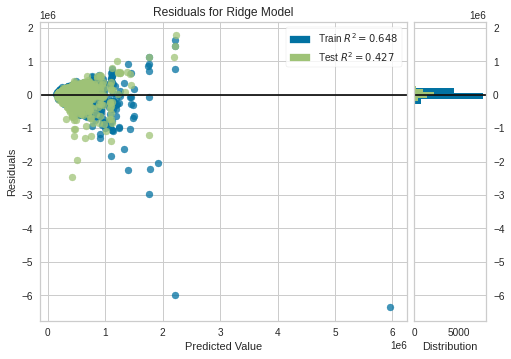

In [24]:
plot_model(tuned)

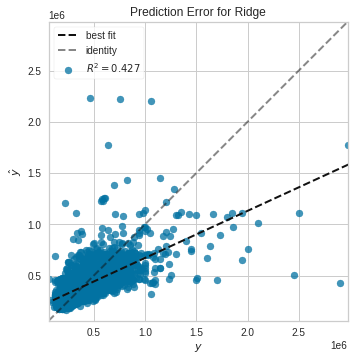

In [25]:
plot_model(tuned, plot = 'error')

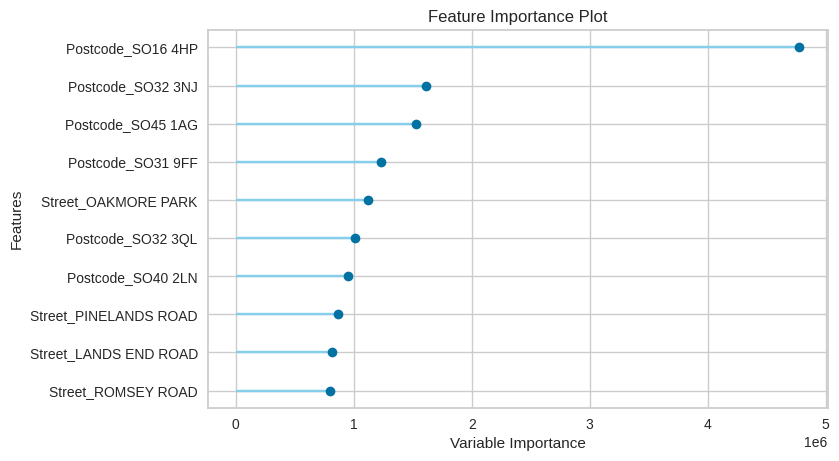

In [26]:
plot_model(tuned, plot='feature')

# Analyse data
Look at the distribution of the amount paid per house across the UK

In [15]:
uk_map = gpd.read_file('ShapeData/Counties/Counties_and_Unitary_Authorities_(December_2020)_UK_BUC.shp')
uk_map.head()

,OBJECTID,CTYUA20CD,CTYUA20NM,CTYUA20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.67614,9.602987e+07,51065.295913,"POLYGON ((448906.042 536703.720, 448926.003 53..."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.54467,5.523139e+07,35500.386745,"POLYGON ((451894.389 521145.406, 453997.697 51..."
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.56752,2.483428e+08,78449.389240,"POLYGON ((478227.056 518780.442, 477689.303 51..."
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.55691,2.052314e+08,87566.566061,"POLYGON ((452185.294 526288.478, 451741.384 52..."
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.53534,1.988128e+08,91926.839545,"POLYGON ((436388.002 522354.197, 437351.702 52..."


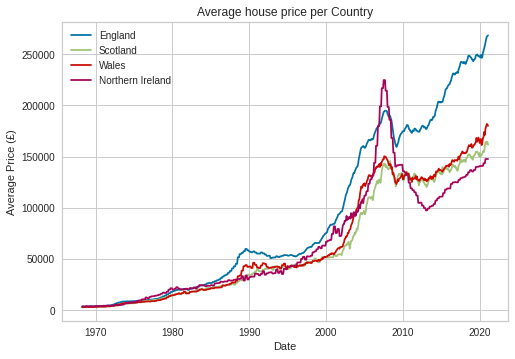

In [29]:
fig, ax = plt.subplots()

# x = pd.to_datetime(hpi.loc[counties[0]].index,dayfirst=True)
# x1 = pd.to_datetime([i[1] for i in hpi.index],dayfirst=True)
# y = hpi['AveragePrice']
mean_price = []
mean_start = []
for i in countries:
    # date_mask = hpi['Date'].loc[countries[i]] >= pd.to_datetime("01-01-2012",dayfirst=True)
    # x = hpi['Date'].loc[counties[i]][date_mask]
    ax.plot(hpi['Date'].loc[i],hpi['AveragePrice'].loc[i])

ax.legend(countries)
# ax.hist(mean_price,bins=50)
# ax.set_xlim(pd.to_datetime('2012'),pd.to_datetime('2021'))
# ax.set_xticks(pd.to_datetime(['2012','2014','2016','2018','2020']))
# ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_title('Average house price per Country')
ax.set_xlabel('Date')
ax.set_ylabel('Average Price (£)')
pass

combine population growth with hpi

In [39]:
population = pd.read_csv('RawData/Population Data/PopulationData.csv',
                         index_col='Name')
population.head()

,Code,Geography1,Area (sq km),Estimated Population mid-2019,2019 people per sq. km,Estimated Population mid-2018,2018 people per sq. km,Estimated Population mid-2017,2017 people per sq. km,Estimated Population mid-2016,2016 people per sq. km,Estimated Population mid-2015,2015 people per sq. km,Estimated Population mid-2014,2014 people per sq. km,Estimated Population mid-2013,2013 people per sq. km,Estimated Population mid-2012,2012 people per sq. km,Estimated Population mid-2011,2011 people per sq. km,Estimated Population mid-2010,2010 people per sq. km,Estimated Population mid-2009,2009 people per sq. km,Estimated Population mid-2008,2008 people per sq. km,Estimated Population mid-2007,2007 people per sq. km,Estimated Population mid-2006,2006 people per sq. km,Estimated Population mid-2005,2005 people per sq. km,Estimated Population mid-2004,2004 people per sq. km,Estimated Population mid-2003,2003 people per sq. km,Estimated Population mid-2002,2002 people per sq. km,Estimated Population mid-2001,2001 people per sq. km
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
UNITED KINGDOM,K02000001,Country,"242,743","66,796,807",275,"66,435,550",274,"66,040,229",272,"65,648,054",270,"65,110,034",268,"64,596,752",266,"64,105,654",264,"63,705,030",262,"63,285,145",261,"62,759,456",259,"62,260,486",256,"61,823,772",255,"61,319,075",253,"60,827,067",251,"60,413,276",249,"59,950,364",247,"59,636,662",246,"59,365,677",245,"59,113,016",244
GREAT BRITAIN,K03000001,Country,"228,950","64,903,140",283,"64,553,909",282,"64,169,395",280,"63,785,917",279,"63,258,413",276,"62,756,254",274,"62,275,929",272,"61,881,396",270,"61,470,827",268,"60,954,623",266,"60,467,153",264,"60,044,620",262,"59,557,392",260,"59,083,954",258,"58,685,543",256,"58,236,322",254,"57,931,738",253,"57,668,143",252,"57,424,178",251
ENGLAND AND WALES,K04000001,Country,"151,047","59,439,840",394,"59,115,809",391,"58,744,595",389,"58,381,217",387,"57,885,413",383,"57,408,654",380,"56,948,229",377,"56,567,796",375,"56,170,927",372,"55,692,423",369,"55,235,253",366,"54,841,720",363,"54,387,392",360,"53,950,854",357,"53,575,343",355,"53,152,022",352,"52,863,238",350,"52,602,143",348,"52,359,978",347
ENGLAND,E92000001,Country,"130,311","56,286,961",432,"55,977,178",430,"55,619,430",427,"55,268,067",424,"54,786,327",420,"54,316,618",417,"53,865,817",413,"53,493,729",411,"53,107,169",408,"52,642,452",404,"52,196,381",401,"51,815,853",398,"51,381,093",394,"50,965,186",391,"50,606,034",388,"50,194,600",385,"49,925,517",383,"49,679,267",381,"49,449,746",379
NORTH EAST,E12000001,Region,"8,579","2,669,941",311,"2,657,909",310,"2,644,727",308,"2,636,589",307,"2,624,579",306,"2,618,736",305,"2,610,563",304,"2,602,387",303,"2,596,441",303,"2,586,868",302,"2,575,441",300,"2,569,312",299,"2,562,045",299,"2,552,568",298,"2,547,127",297,"2,540,502",296,"2,540,461",296,"2,540,600",296,"2,540,090",296


In [41]:
population.loc[uk_map['CTYUA20NM']].head()

,Code,Geography1,Area (sq km),Estimated Population mid-2019,2019 people per sq. km,Estimated Population mid-2018,2018 people per sq. km,Estimated Population mid-2017,2017 people per sq. km,Estimated Population mid-2016,2016 people per sq. km,Estimated Population mid-2015,2015 people per sq. km,Estimated Population mid-2014,2014 people per sq. km,Estimated Population mid-2013,2013 people per sq. km,Estimated Population mid-2012,2012 people per sq. km,Estimated Population mid-2011,2011 people per sq. km,Estimated Population mid-2010,2010 people per sq. km,Estimated Population mid-2009,2009 people per sq. km,Estimated Population mid-2008,2008 people per sq. km,Estimated Population mid-2007,2007 people per sq. km,Estimated Population mid-2006,2006 people per sq. km,Estimated Population mid-2005,2005 people per sq. km,Estimated Population mid-2004,2004 people per sq. km,Estimated Population mid-2003,2003 people per sq. km,Estimated Population mid-2002,2002 people per sq. km,Estimated Population mid-2001,2001 people per sq. km
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Hartlepool,E06000001,Unitary Authority,94,"93,663",999,"93,242",995,"93,019",993,"92,845",991,"92,498",987,"92,606",988,"92,662",989,"92,261",985,"92,088",983,"91,773",979,"91,530",977,"91,379",975,"90,969",971,"90,781",969,"90,457",965,"90,317",964,"90,134",962,"89,993",960,"90,152",962
Middlesbrough,E06000002,Unitary Authority,54,"140,980","2,616","140,545","2,608","140,639","2,610","140,326","2,604","139,310","2,585","138,991","2,580","138,911","2,578","138,726","2,575","138,368","2,568","137,667","2,555","137,273","2,548","137,885","2,559","138,190","2,565","138,169","2,564","138,517","2,571","138,451","2,570","139,050","2,581","140,090","2,600","141,233","2,621"
Redcar and Cleveland,E06000003,Unitary Authority,245,"137,150",560,"136,718",558,"136,005",555,"135,496",553,"135,324",552,"135,102",551,"134,960",551,"134,976",551,"135,164",552,"135,383",552,"135,867",554,"136,512",557,"136,940",559,"137,621",562,"138,177",564,"138,643",566,"138,565",565,"138,520",565,"139,159",568
Stockton-on-Tees,E06000004,Unitary Authority,205,"197,348",963,"197,213",962,"196,487",959,"195,958",956,"195,128",952,"194,423",949,"193,433",944,"192,487",939,"191,824",936,"190,902",932,"189,978",927,"189,039",922,"187,937",917,"187,270",914,"186,350",909,"185,687",906,"185,699",906,"184,940",902,"183,795",897
Darlington,E06000005,Unitary Authority,197,"106,803",541,"106,566",540,"106,347",539,"106,327",538,"105,998",537,"105,877",536,"105,726",535,"105,503",534,"105,584",535,"105,028",532,"104,355",528,"103,694",525,"102,632",520,"101,509",514,"100,287",508,"99,343",503,"98,911",501,"98,474",499,"97,894",496


In [54]:
population = population.loc[uk_map['CTYUA20NM']]
# new_map = gpd.GeoDataFrame(pd.concat([uk_map, population],ignore_index=True),crs=uk_map.crs)
uk_map['pop 2019'] = list(map(lambda x : int(x.replace(',','')),population['Estimated Population mid-2019']))
uk_map['pop 2001'] = list(map(lambda x : int(x.replace(',','')),population['Estimated Population mid-2001']))
uk_map['pop 2019-2001'] = uk_map['pop 2019'] - uk_map['pop 2001']
uk_map.head()

,OBJECTID,CTYUA20CD,CTYUA20NM,CTYUA20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,pop 2019,pop 2001,pop 2019-2001
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.67614,9.602987e+07,51065.295913,"POLYGON ((448906.042 536703.720, 448926.003 53...",93663,90152,3511
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.54467,5.523139e+07,35500.386745,"POLYGON ((451894.389 521145.406, 453997.697 51...",140980,141233,-253
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.56752,2.483428e+08,78449.389240,"POLYGON ((478227.056 518780.442, 477689.303 51...",137150,139159,-2009
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.55691,2.052314e+08,87566.566061,"POLYGON ((452185.294 526288.478, 451741.384 52...",197348,183795,13553
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.53534,1.988128e+08,91926.839545,"POLYGON ((436388.002 522354.197, 437351.702 52...",106803,97894,8909


<AxesSubplot:>

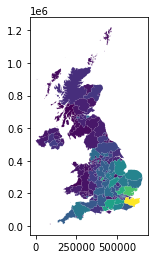

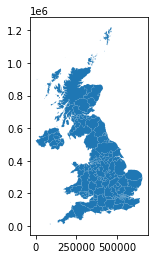

In [56]:
uk_map.plot(column='pop 2019-2001')
uk_map.plot()

Average price for housing in the UK has accelerated in England at a higher rate over the last 10 years in comparison to Northern Ireland, Scotland, and Wales.

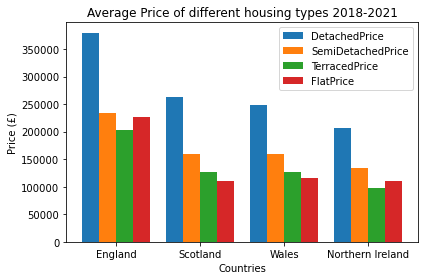

In [99]:

fig, ax = plt.subplots()

housing = ['DetachedPrice','SemiDetachedPrice','TerracedPrice','FlatPrice']
bar_lab = []
x = np.arange(len(housing))
width = 0.2
widths = -0.3, -0.1, 0.1, 0.3

for i,ihouse in enumerate(housing):
    tmp_list = []
    for j in countries:
        date_mask = hpi['Date'].loc[j] >= pd.to_datetime("01-01-2018",dayfirst=True)
        tmp_list.append(hpi[ihouse].loc[j][date_mask].mean())
    bar_lab.append(ax.bar(x+widths[i], tmp_list, width, label=ihouse))

# for i in countries:
#     date_mask = hpi['Date'].loc[i] >= pd.to_datetime("01-01-2018",dayfirst=True)
#     ax.scatter([i]*4,[hpi['DetachedPrice'].loc[i][date_mask].mean(),
#                       hpi['SemiDetachedPrice'].loc[i][date_mask].mean(),
#                       hpi['TerracedPrice'].loc[i][date_mask].mean(),
#                       hpi['FlatPrice'].loc[i][date_mask].mean()
#                       ])
#     print(i,[hpi['DetachedPrice'].loc[i][date_mask].mean(),
#                   hpi['SemiDetachedPrice'].loc[i][date_mask].mean(),
#                   hpi['TerracedPrice'].loc[i][date_mask].mean(),
#                   hpi['FlatPrice'].loc[i][date_mask].mean()])

ax.set_ylabel('Price (£)')
ax.set_xlabel('Countries')
ax.set_xticks(x)
ax.set_xticklabels(countries)
ax.set_title('Average Price of different housing types 2018-2021')
ax.legend()

fig.tight_layout()
pass

Detached homes are significantly more expensive, with most housing types in England costing close to double their counterparts in Scotland, Wales, and Northern Ireland.  

---  
## Maps of UK counties

In [135]:
# uk_map.iloc[ for i in hpi_new.index]]

# new_map = []
# for i in set(hpi_new.index):
#     tmp = list(i==uk_map['CTYUA20NM'])
#     new_map.append(uk_map.iloc[tmp])
# new_map = gpd.GeoDataFrame(pd.concat(new_map))
# new_map['SaleDif'] = sale_dif
# new_map.head()
# new_map = uk_map.iloc[[(i==uk_map['CTYUA20NM']) for i in set(hpi_new.index)]]

ValueError: Length of values (162) does not match length of index (200)

In [165]:
hpi_new = hpi.loc[[i for i in uk_map['CTYUA20NM'] if i in hpi.index]]
# hpi_new.index = uk_map.index
# county_map = pd.concat([hpi[['DetachedPrice','SemiDetachedPrice','TerracedPrice','FlatPrice','SalesVolume',
#             'FTBPrice','FOOPrice','NewSalesVolume','OldSalesVolume','NewPrice','OldPrice']].loc[i],uk_map])

hpi['Date'] = pd.to_datetime(hpi['Date'],dayfirst=True)
hpi_2001 = hpi.iloc[:][(pd.to_datetime("01,01,2001") <= hpi['Date']) & (hpi['Date'] < pd.to_datetime("01,01,2002"))]
hpi_2019 = hpi.iloc[:][(pd.to_datetime("01,01,2019") <= hpi['Date']) & (hpi['Date'] < pd.to_datetime("01,01,2020"))]
uk_map['sale_dif'] = float('nan')
for k,i in enumerate(uk_map['CTYUA20NM']):
    try:
        if i in hpi.index:
            tmp_2001 = hpi_2001['SalesVolume'].loc[i].sum()
            tmp_2019 = hpi_2019['SalesVolume'].loc[i].sum()
            uk_map['sale_dif'].iloc[k] = tmp_2019 - tmp_2001
    except:
        continue
#     else:
#         uk_map['sale_dif'].iloc[k] = float('nan')

Text(0.5, 1.0, 'Sales Volume growth by County\nbetween 2001 and 2019')

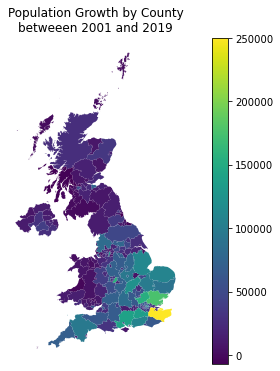

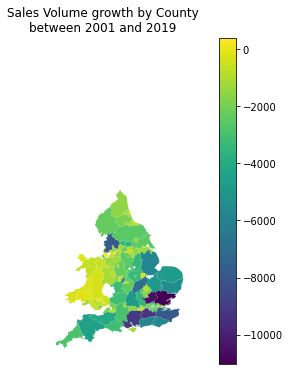

In [183]:
fig1, ax1 = plt.subplots(1, figsize=(10, 6))
uk_map.plot(column='pop 2019-2001',legend=True,ax=ax1)
ax1.axis('off')
ax1.set_title('Population Growth by County\nbetweeen 2001 and 2019')#, fontdict={'fontsize': '25', 'fontweight' : '3'})

fig2, ax2 = plt.subplots(1, figsize=(10, 6))
uk_map.plot(column='sale_dif',legend=True,ax=ax2)
ax2.axis('off')
ax2.set_title('Sales Volume growth by County\nbetween 2001 and 2019')